In [250]:
import kaleido
import pandas as pd
import georasters as gr
import os
import geopandas as gpd
from shapely.geometry import Point
import urllib.request
import json
import plotly.express as px
import urllib.request
import json
from shapely.geometry import Polygon
import numpy as np
import seaborn as sns


Social Vulnerability, or “SVI”, measures social conditions of a community and its vulnerability to
human suffering and financial loss in the event of a disaster. It is primarily used by public
officials and emergency response planners to identify communities in need of support. SVI can
be grouped into four themes: 1) socioeconomic status 2) household characteristics 3) racial and
ethnic minority status 4) housing type and transportation. These themes are composed of
separate variables that are used to compute the theme value. There are 16 total individual
variables; they include persons below 150% poverty, persons unemployed, aged 65 & older,
civilians with a disability, etc. The four themes were used in this project and can be broken
down as follows: socioeconomic status – describes income, poverty, education and
employment; household composition – describes age, disability, and single parenting; minority
status – describes race and ethnicity; housing type – describes housing structure, vehicle access
and crowding. Additionally, the census variables: total population for a tract, housing units
within a tract, number of households within a tract, and unemployment rate were also
considered in this project. 

Data Source: 
https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html


In [251]:
svi_2014=pd.read_csv("data\SVI_2014_US.csv")
svi_2014['Date']=2014

svi_2016=pd.read_csv("data\SVI_2016_US.csv")
svi_2016['Date']=2016

svi_2018=pd.read_csv("data\SVI_2018_US.csv")
svi_2018['Date']=2018

svi_2020=pd.read_csv("data\SVI_2020_US.csv")
svi_2020['Date']=2020

SVI data cleaning

In [252]:
match_fields=set(svi_2014.columns) & set(svi_2016.columns) & set(svi_2018.columns) & set(svi_2020.columns)
match_fields=list(match_fields)

svi_2014=svi_2014[match_fields]
svi_2016=svi_2016[match_fields]
svi_2018=svi_2018[match_fields]
svi_2020=svi_2020[match_fields]

svi = pd.concat([svi_2014, svi_2016,svi_2018,svi_2020])
svi.shape

(82269, 112)

In [253]:
svi['STCNTY'] = svi['FIPS'].astype(int).astype(str).apply(lambda x: '{0:0>5}'.format(x))
svi['Date'] = pd.to_datetime(svi['Date'].map(str)).dt.strftime('%Y')
svi.sort_values(by='Date', inplace=True)

In [254]:
svi_codes=svi[['STCNTY','Date','STATE','LOCATION','COUNTY','ST_ABBR']]
print(svi_codes)
#svi_codes.to_pickle('data\county_ids')
svi=svi.drop(['STATE','LOCATION','COUNTY','ST_ABBR'], axis=1)
svi=svi.groupby(['STCNTY','Date'],as_index=False).mean()
#pd.set_option('display.max_columns', None)
display(svi.head(5))

            STCNTY  Date            STATE  \
0       1001020100  2014          Alabama   
48553  -1589685464  2014   North Carolina   
48554  -1589685364  2014   North Carolina   
48555  -1589685264  2014   North Carolina   
48556  -1589685064  2014   North Carolina   
...            ...   ...              ...   
1050         21113  2020         Kentucky   
1051         21115  2020         Kentucky   
1052         21117  2020         Kentucky   
1054         21121  2020         Kentucky   
3142         56045  2020          Wyoming   

                                                LOCATION      COUNTY ST_ABBR  
0              Census Tract 201, Autauga County, Alabama     Autauga      AL  
48553  Census Tract 202, Edgecombe County, North Caro...   Edgecombe      NC  
48554  Census Tract 203, Edgecombe County, North Caro...   Edgecombe      NC  
48555  Census Tract 204, Edgecombe County, North Caro...   Edgecombe      NC  
48556  Census Tract 206, Edgecombe County, North Caro...   Edgec

,STCNTY,Date,F_THEME1,E_HH,E_CROWD,EPL_UNEMP,EPL_LIMENG,M_LIMENG,EPL_DISABL,M_HU,EP_UNEMP,EP_CROWD,EP_MOBILE,M_TOTPOP,EP_NOVEH,RPL_THEME4,ST,MP_MOBILE,EPL_MUNIT,SPL_THEME3,E_UNEMP,MP_AGE65,EP_SNGPNT,EPL_CROWD,MP_NOHSDP,M_NOHSDP,M_GROUPQ,M_AGE17,MP_LIMENG,EPL_GROUPQ,F_NOHSDP,MP_CROWD,E_DISABL,M_MUNIT,M_NOVEH,M_UNEMP,EP_LIMENG,F_TOTAL,E_GROUPQ,E_MOBILE,EPL_MOBILE,RPL_THEME1,F_AGE65,EP_AGE17,F_SNGPNT,MP_GROUPQ,EPL_AGE17,MP_UNINSUR,MP_AGE17,F_GROUPQ,MP_DISABL,E_SNGPNT,F_UNEMP,F_LIMENG,MP_UNEMP,M_HH,RPL_THEME2,M_CROWD,EP_UNINSUR,EPL_MINRTY,AREA_SQMI,EPL_SNGPNT,EPL_NOVEH,E_HU,SPL_THEME4,EP_MUNIT,E_MUNIT,FIPS,EP_GROUPQ,MP_MUNIT,EPL_AGE65,E_MINRTY,E_AGE17,F_THEME3,F_MOBILE,MP_MINRTY,MP_NOVEH,E_NOHSDP,EP_NOHSDP,M_SNGPNT,E_AGE65,F_NOVEH,SPL_THEME2,E_NOVEH,M_DISABL,RPL_THEMES,M_MOBILE,EPL_NOHSDP,E_TOTPOP,F_THEME2,F_CROWD,SPL_THEME1,F_DISABL,RPL_THEME3,F_AGE17,M_UNINSUR,MP_SNGPNT,SPL_THEMES,M_AGE65,F_MINRTY,M_MINRTY,E_LIMENG,F_MUNIT,EP_MINRTY,EP_AGE65,E_UNINSUR,E_DAYPOP,EP_DISABL,F_THEME4
0,-1001690872,2014,0.0,1573.0,7.0,0.3949,0.1721,42.6,0.5191,101.0,7.3,0.4,12.3,254.0,2.7,0.1910,29.0,3.0,0.2427,0.2045,151.0,2.5,5.1,0.2395,2.3,66.0,11.0,115.0,1.2,0.0000,0.0,0.5,490.0,6.4,18.0,56.0,0.0,0.0,0.0,214.0,0.8144,0.3644,0.0,22.3,0.0,0.3,0.4560,1.8,2.5,0.0,1.9,81.0,0.0,0.0,2.5,97.0,0.4883,7.2,8.2,0.0325,212.201709,0.2562,0.2593,1733.0,1.5559,0.3,6.0,2.906308e+10,0.0,0.4,0.7802,80.0,878.0,0.0,0.0,9.1,1.1,220.0,8.0,34.7,725.0,0.0,2.0114,43.0,77.0,0.2049,54.0,0.3498,3940.0,0.0,0.0,1.5292,0.0,0.0807,0.0,75.0,2.2,5.3011,108.0,0.0,358.5,1.0,0.0,2.0,18.4,322.0,2312.0,12.4,0.0
1,-1001690972,2014,1.0,2205.0,0.0,0.2669,0.3213,70.9,0.8951,188.0,5.9,0.0,16.6,254.0,9.8,0.8116,29.0,6.0,0.5526,0.7768,151.0,1.1,6.0,0.0000,3.1,210.0,326.0,114.0,0.8,0.9860,0.0,1.0,1099.0,58.0,105.0,89.0,0.5,2.0,3505.0,427.0,0.8616,0.6324,0.0,15.0,0.0,3.5,0.1065,3.3,1.2,1.0,3.8,133.0,0.0,0.0,3.3,210.0,0.3514,21.2,11.3,0.4555,209.155889,0.3248,0.7026,2573.0,3.1028,5.8,148.0,2.906308e+10,39.5,2.2,0.4789,2096.0,1330.0,0.0,0.0,4.8,4.7,1221.0,18.0,71.2,1184.0,0.0,1.8054,215.0,228.0,0.6225,160.0,0.7140,8884.0,0.0,0.0,2.4042,0.0,0.3760,0.0,197.0,3.2,8.0892,104.0,0.0,428.4,41.0,0.0,23.6,13.3,613.0,9441.0,20.3,1.0
2,-1003300872,2014,0.0,1830.0,65.0,0.2761,0.3841,57.8,0.7468,60.0,6.0,3.6,8.4,191.0,9.5,0.8288,29.0,2.2,0.3543,0.4389,130.0,1.2,7.2,0.7040,2.7,85.0,51.0,96.0,1.2,0.6422,0.0,1.6,804.0,18.4,42.0,43.0,0.7,0.0,35.0,197.0,0.7584,0.5936,0.0,28.5,0.0,1.0,0.8257,3.7,1.6,0.0,2.2,131.0,0.0,0.0,1.9,94.0,0.8544,28.6,25.1,0.0548,226.862338,0.4132,0.6926,2343.0,3.1516,1.4,33.0,2.906147e+10,0.7,0.8,0.6455,147.0,1420.0,0.0,0.0,5.4,2.3,490.0,15.4,42.7,792.0,0.0,2.6313,174.0,107.0,0.6794,52.0,0.6441,4991.0,0.0,0.0,2.2753,0.0,0.1904,0.0,192.0,2.3,8.4972,59.0,0.0,268.0,33.0,0.0,2.9,15.9,1244.0,4327.0,16.2,0.0
3,-1003300972,2014,0.0,1304.0,66.0,0.3023,0.5526,46.6,0.6536,79.0,6.3,5.1,18.0,191.0,5.0,0.7768,29.0,3.4,0.0000,0.6327,90.0,1.9,3.0,0.7952,3.0,71.0,70.0,94.0,1.5,0.8765,0.0,2.7,462.0,15.6,27.0,32.0,1.7,0.0,133.0,337.0,0.8747,0.5719,0.0,21.9,0.0,2.1,0.4282,4.3,2.5,0.0,2.2,39.0,0.0,0.0,2.2,90.0,0.5312,35.2,18.2,0.0801,336.373723,0.1110,0.4624,1869.0,3.0089,0.0,0.0,2.906147e+10,4.0,0.8,0.8775,128.0,730.0,0.0,0.0,8.0,2.1,358.0,15.3,18.4,705.0,0.0,2.0704,65.0,73.0,0.5975,65.0,0.6411,3333.0,0.0,0.0,2.1991,0.0,0.2949,0.0,139.0,1.4,7.9111,60.0,0.0,268.0,54.0,0.0,3.8,21.2,582.0,1707.0,14.5,0.0
4,-1005290772,2014,0.0,2482.0,136.0,0.8702,0.3890,79.3,0.7046,147.0,16.0,5.5,16.3,515.0,2.4,0.3038,29.0,6.0,0.0000,0.4843,519.0,1.8,5.9,0.8130,4.7,217.0,15.0,250.0,1.3,0.0000,0.0,4.3,1025.0,21.2,53.0,211.0,0.7,0.0,0.0,475.0,0.8585,0.8545,0.0,22.3,0.0,0.2,0.4574,6.2,3.3,0.0,3.1,146.0,0.0,0.0,6.4,212.0,0.4751,108.0,24.8,0.0953,216.046348,0.3139,0.2295,2907.0,1.9011,0.0,0.0,2.905948e+10,0.0,0.7,0.5177,291.0,1486.0,0.0,0.0,11.1,2.1,909.0,20.0,89.9,928.0,0.0,1.9935,60.0,204.0,0.5514,178.0,0.7604,6663.0,0.0,0.0,3.2238,0.0,0.2143,0.0,419.0,3.6,7.6026,98.0,0.0,741.9,46.0,0.0,4.4,13.9,1653.0,3830.0,15.4,0.0


In [255]:
svi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82269 entries, 0 to 82268
Columns: 109 entries, STCNTY to F_THEME4
dtypes: float64(107), object(2)
memory usage: 68.4+ MB


Data processing was initially performed using CO2 data obtained from NASA’s OCO-2 mission
and via NASA’s Goddard Earth Sciences Data and Information Services Center (Goddard Earth
Sciences Data and Information Services Center, 2018). This dataset consists of 3 km2
rectangular raster bands. OCO-2 data possesses significant discontinuity due to the satellite’s
path, poor quality flagging, and sparce observations with irregular frequencies. A given location
can have between 2 and 50 high-quality observations per year. Not enough values were present
in the OCO-2 dataset alone to conduct imputation of missing values. In addition to the
discontinuity of the observations, even with projection and interpolation, the raster bands were
difficult to spatially join with other geodata.

Instead, we harnessed the work of researchers, Sheng et al. (2022), who produced a more
complete CO2 emissions dataset. Using geostatistical techniques, they combined the OCO-2 and
GOSAT missions producing a complete global emission dataset with a 1° square pixel resolution
at both 3-day and monthly frequencies from 2009-2020 9
. Our work aggregates the monthly
values into annual means and standard deviations which removes the seasonal trend present in
any CO2 data (visible in Figure 4) and captures variation. Each pixel was interpolated and
labeled with a with a latitude and longitude coordinate pair.

Data Source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/4WDTD8

Sample output from one month of readings

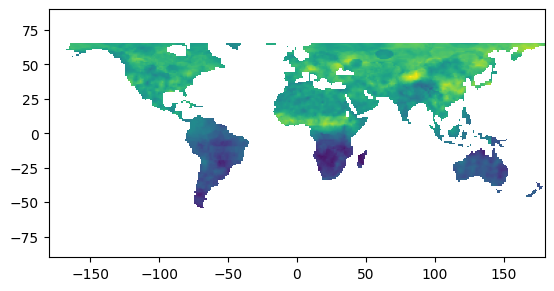

<Axes: >

In [256]:
import rasterio
from rasterio.plot import show
fp = r'data\MappingXCO2_month\MappingXCO2_201002.tif'
img = rasterio.open(fp)
show(img)

XCO2 data cleaning

In [257]:
xco2_data=pd.DataFrame()
directory = os.fsencode('data\MappingXCO2_month')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    year=filename[12:16]
    month=filename[16:18]
    data=gr.from_file(f'data\MappingXCO2_month\{filename}').to_pandas().iloc[:,[2,3,4]]
    data = data.rename(columns={True: 'xco2', 'x': 'lon', 'y':'lat'})
    data['year']=year
    data['month']=month
    xco2_data = pd.concat([xco2_data, data])
    
xco2_data = xco2_data[(xco2_data['lon'] >= -180.00) & (xco2_data['lon'] <= -65.00)]
xco2_data = xco2_data[(xco2_data['lat'] >= 17.00) & (xco2_data['lat'] <= 72.00)]
xco2_data['coords']=list(zip(xco2_data['lon'],xco2_data['lat']))
xco2_data['coords']=xco2_data['coords'].apply(Point)

display(xco2_data.head())

,xco2,lon,lat,year,month,coords
0,388.695338,-167.0,65.0,2009,04,POINT (-167 65)
1,388.578295,-166.0,65.0,2009,04,POINT (-166 65)
2,389.344642,-165.0,65.0,2009,04,POINT (-165 65)
3,390.086970,-164.0,65.0,2009,04,POINT (-164 65)
4,390.647728,-163.0,65.0,2009,04,POINT (-163 65)


In [258]:
xco2_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357153 entries, 0 to 9445
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   xco2    357153 non-null  float64
 1   lon     357153 non-null  float64
 2   lat     357153 non-null  float64
 3   year    357153 non-null  object 
 4   month   357153 non-null  object 
 5   coords  357153 non-null  object 
dtypes: float64(3), object(3)
memory usage: 19.1+ MB


Grouping XCO2 measurements by united states county. 

County boundaries obtained from: https://github.com/plotly/datasets

In [259]:
request = urllib.request.Request('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')
opener = urllib.request.build_opener()
response = opener.open(request)
counties_map = json.load(response)

counties=gpd.GeoDataFrame.from_features(counties_map["features"])
id = pd.json_normalize(counties_map, record_path =['features'])[['id']]
counties['geoid']=id

points = gpd.GeoDataFrame(xco2_data, geometry='coords', crs=counties.crs)
xco2_mo = gpd.sjoin_nearest(counties,points, how='left')

xco2_mo=xco2_mo[['xco2','year','month','geoid']]
xco2_mo=xco2_mo.groupby(['geoid','year','month'],as_index=False).mean()
xco2_mo['date'] = pd.to_datetime(xco2_mo[['year', 'month']].assign(DAY=1))

display(xco2_mo.head())

,geoid,year,month,xco2,date
0,01001,2009,04,389.638553,2009-04-01
1,01001,2009,05,388.796152,2009-05-01
2,01001,2009,06,386.257960,2009-06-01
3,01001,2009,07,384.076832,2009-07-01
4,01001,2009,08,382.997560,2009-08-01


In [260]:
xco2_mo_plot=xco2_mo.groupby(['year','month'],as_index=False).mean()
xco2_mo_plot['date']=xco2_mo_plot['date'].dt.strftime('%Y-%m')

In [261]:
xco2_mo_plot['date']= pd.to_datetime(xco2_mo_plot['date'])

In [262]:
display(xco2_mo_plot.head())

,year,month,geoid,xco2,date
0,2009,04,inf,389.280546,2009-04-01
1,2009,05,inf,388.638075,2009-05-01
2,2009,06,inf,386.499811,2009-06-01
3,2009,07,inf,383.623260,2009-07-01
4,2009,08,inf,381.975034,2009-08-01


Plotting change average xco2 value in the United States over time

In [263]:
import plotly

fig = px.scatter(xco2_mo_plot, x="date", y="xco2",  labels={
    "date": "Date",
    "xco2": "Column Averaged CO2 (ppm)",
    "species": "Species of Iris"},
    template='plotly_dark',
    trendline='ols')
fig.update_layout(title_text='United States Column Averaged CO2 Levels Over time (2009-2020)', title_x=0.5)
fig.update_traces(mode = 'lines')
fig.data[-1].line.color = 'red'
fig.update_xaxes(
    dtick="M3")
fig.show()

if not os.path.exists("images"):
    os.mkdir("images")
    
plotly.offline.plot(fig, filename='images/co2_vs_time.html')

'images/co2_vs_time.html'

In [264]:
xco2_yr=xco2_mo.drop(['month','date'], axis=1)
xco2_yr=xco2_yr.groupby(['geoid','year'],as_index=False).mean()
display(xco2_yr.head(15))
print(xco2_yr.shape)

,geoid,year,xco2
0,01001,2009,385.952529
1,01001,2010,388.688702
2,01001,2011,390.605063
3,01001,2012,392.608795
4,01001,2013,395.329764
5,01001,2014,397.493360
6,01001,2015,400.242484
7,01001,2016,403.473623
8,01001,2017,405.425648
9,01001,2018,407.631516


(38652, 3)


In [265]:
svi_co2=pd.merge(svi, xco2_yr, left_on=['STCNTY','Date'], right_on=['geoid','year'])
svi_co2=svi_co2.dropna()
svi_co2.shape

(9419, 112)

In [266]:
display(svi_co2.head())

,STCNTY,Date,F_THEME1,E_HH,E_CROWD,EPL_UNEMP,EPL_LIMENG,M_LIMENG,EPL_DISABL,M_HU,EP_UNEMP,EP_CROWD,EP_MOBILE,M_TOTPOP,EP_NOVEH,RPL_THEME4,ST,MP_MOBILE,EPL_MUNIT,SPL_THEME3,E_UNEMP,MP_AGE65,EP_SNGPNT,EPL_CROWD,MP_NOHSDP,M_NOHSDP,M_GROUPQ,M_AGE17,MP_LIMENG,EPL_GROUPQ,F_NOHSDP,MP_CROWD,E_DISABL,M_MUNIT,M_NOVEH,M_UNEMP,EP_LIMENG,F_TOTAL,E_GROUPQ,E_MOBILE,EPL_MOBILE,RPL_THEME1,F_AGE65,EP_AGE17,F_SNGPNT,MP_GROUPQ,EPL_AGE17,MP_UNINSUR,MP_AGE17,F_GROUPQ,MP_DISABL,E_SNGPNT,F_UNEMP,F_LIMENG,MP_UNEMP,M_HH,RPL_THEME2,M_CROWD,EP_UNINSUR,EPL_MINRTY,AREA_SQMI,EPL_SNGPNT,EPL_NOVEH,E_HU,SPL_THEME4,EP_MUNIT,E_MUNIT,FIPS,EP_GROUPQ,MP_MUNIT,EPL_AGE65,E_MINRTY,E_AGE17,F_THEME3,F_MOBILE,MP_MINRTY,MP_NOVEH,E_NOHSDP,EP_NOHSDP,M_SNGPNT,E_AGE65,F_NOVEH,SPL_THEME2,E_NOVEH,M_DISABL,RPL_THEMES,M_MOBILE,EPL_NOHSDP,E_TOTPOP,F_THEME2,F_CROWD,SPL_THEME1,F_DISABL,RPL_THEME3,F_AGE17,M_UNINSUR,MP_SNGPNT,SPL_THEMES,M_AGE65,F_MINRTY,M_MINRTY,E_LIMENG,F_MUNIT,EP_MINRTY,EP_AGE65,E_UNINSUR,E_DAYPOP,EP_DISABL,F_THEME4,geoid,year,xco2
0,01001,2016,0.0,20800.0,254.0,0.3298,0.5355,163.3,0.7380,75.0,5.6,1.2,18.0,0.0,4.9,0.2881,1.0,1.7,0.6791,1.1694,1437.0,0.2,7.3,0.2477,1.2,445.0,163.0,34.0,0.3,0.1251,0.0,0.5,10009.0,329.9,242.0,277.0,0.8,0.0,490.0,4095.0,0.7268,0.3298,0.0,25.2,0.0,0.3,0.8313,1.2,0.1,0.0,1.6,1516.0,0.0,0.0,1.1,391.0,0.5568,104.5,8.9,0.6339,594.446120,0.3200,0.3298,22714.0,2.1086,4.6,1034.0,1001.0,0.9,1.5,0.1964,13386.0,13853.0,0.0,0.0,0.3,1.1,4528.0,12.4,267.0,7695.0,0.0,2.0856,1024.0,850.0,0.3773,379.0,0.4744,55049.0,0.0,0.0,1.4473,0.0,0.5976,0.0,649.0,1.3,6.8109,104.0,0.0,161.0,432.0,0.0,24.3,14.0,4852.0,40854.0,18.4,0.0,01001,2016,403.473623
1,01001,2018,0.0,21115.0,299.0,0.2745,0.5113,205.9,0.7905,71.0,4.2,1.4,18.4,0.0,5.6,0.3741,1.0,2.0,0.6017,1.1449,1065.0,0.1,7.5,0.2964,1.3,475.0,161.0,32.0,0.4,0.1525,0.0,0.7,10465.0,308.7,272.0,257.0,0.8,0.0,546.0,4279.0,0.7408,0.3631,0.0,24.2,0.0,0.3,0.7529,0.9,0.1,0.0,1.3,1586.0,0.0,0.0,1.0,383.0,0.5810,142.3,7.1,0.6336,594.443459,0.3792,0.4846,23315.0,2.2760,3.8,886.0,1001.0,1.0,1.3,0.1850,13788.0,13369.0,0.0,0.0,0.1,1.3,4204.0,11.3,319.9,8050.0,0.0,2.1076,1191.0,729.0,0.4354,469.0,0.4397,55200.0,0.0,0.0,1.5403,0.0,0.5947,0.0,508.0,1.5,7.0688,75.0,0.0,59.0,426.0,0.0,25.0,14.6,3875.0,37301.0,19.3,0.0,01001,2018,407.631516
2,01001,2020,0.0,21559.0,339.0,0.1397,0.4736,229.0,0.6830,68.0,2.9,1.6,18.2,0.0,5.4,0.4309,1.0,1.8,0.6050,0.6337,736.0,0.2,7.5,0.4023,1.5,562.0,157.0,49.0,0.4,0.1569,0.0,0.8,9658.0,292.0,320.0,185.0,0.7,0.0,578.0,4313.0,0.7486,0.3838,0.0,23.6,0.0,0.3,0.6986,1.3,0.1,0.0,1.6,1608.0,0.0,0.0,0.7,366.0,0.7362,162.0,8.0,0.6337,594.455838,0.7922,0.4764,23697.0,2.3892,3.9,918.0,1001.0,1.0,1.2,0.1827,14479.0,13143.0,0.0,0.0,1.0,1.5,4273.0,11.3,302.0,8490.0,0.0,2.8301,1167.0,856.0,0.5130,440.0,0.5080,55639.0,0.0,0.0,2.1725,0.0,0.6337,0.0,725.0,1.4,8.0255,85.0,0.0,566.0,363.0,0.0,26.0,15.3,4345.0,41810.0,17.7,0.0,01001,2020,412.982466
3,01003,2016,0.0,75149.0,958.0,0.4241,0.5282,489.6,0.3521,202.0,6.3,1.3,11.9,0.0,3.1,0.3324,1.0,0.9,0.9733,1.0535,5887.0,0.1,6.0,0.2639,0.7,974.0,443.0,0.0,0.3,0.3438,0.0,0.3,27390.0,936.9,342.0,674.0,0.8,1.0,2911.0,12829.0,0.5387,0.2881,0.0,22.2,0.0,0.2,0.4476,0.9,0.0,0.0,0.7,4494.0,0.0,0.0,0.7,1285.0,0.2057,219.1,11.8,0.5253,1589.807425,0.1493,0.0872,107579.0,2.2069,18.3,19711.0,1003.0,1.5,0.9,0.6437,33560.0,44270.0,0.0,0.0,0.1,0.5,13956.0,10.0,589.8,37338.0,0.0,1.5928,2303.0,1430.0,0.2757,935.0,0.2999,199510.0,0.0,0.0,1.3005,0.0,0.5294,0.0,1817.0,0.8,6.1538,79.0,0.0,245.0,1540.0,1.0,16.8,18.7,23255.0,197683.0,13.9,1.0,01003,2016,403.990220
4,01003,2018,0.0,78622.0,991.0,0.3121,0.3582,323.6,0.3524,206.0,4.4,1.3,11.7,0.0,3.4,0.3359,1.0,0.7,0.9713,0.8740,4343.0,0.1,5.7,0.2604,0.8,1211.0,459.0,0.0,0.2,0.3018,0.0,0.3,28863.0,1203.0,443.0,620.0,0.5,1.0,3014.0,13075.0,0.5339,0.2232,0.0,21.9,0.0,0.2,0.4323,0.8,0.0,0.0,0.6,4508.0,0.0,0.0,0.6,1183.0,0.1990,248.5,10.2,0.5158,1589.793007,0.1391,0.1328,111945.0,2.2002,18.3,20492.0,1003.0,1.4,1.1,0.6428,35339.0,45677.0,0.0,0.0,0.1,0.6,

For each year, subtract the annual mean. A simple way of highlighting counties with higher than average XCO2 values

In [267]:
#calculate yearly averages
grouped=svi_co2.groupby('year')
averaged=grouped.mean()
print(averaged['xco2'])

conditions = [
    (svi_co2['year'] == '2014'),
    (svi_co2['year'] == '2016'),
    (svi_co2['year'] == '2018'),
    (svi_co2['year'] == '2020')
    ]
values = [397.557046, 403.399761, 407.916993, 412.896790]

svi_co2['yr_avg'] = np.select(conditions, values)

svi_co2['adj_xco2']=svi_co2['xco2']-svi_co2['yr_avg']
display(svi_co2['adj_xco2'])

year
2016    403.399761
2018    407.916993
2020    412.896790
Name: xco2, dtype: float64


0       0.073862
1      -0.285477
2       0.085676
3       0.590459
4       0.279942
          ...   
9414   -0.164761
9415   -0.111221
9416   -0.238111
9417   -0.441622
9418   -0.391382
Name: adj_xco2, Length: 9419, dtype: float64

Adding back county and state info

In [268]:
display(svi_co2.head())

,STCNTY,Date,F_THEME1,E_HH,E_CROWD,EPL_UNEMP,EPL_LIMENG,M_LIMENG,EPL_DISABL,M_HU,EP_UNEMP,EP_CROWD,EP_MOBILE,M_TOTPOP,EP_NOVEH,RPL_THEME4,ST,MP_MOBILE,EPL_MUNIT,SPL_THEME3,E_UNEMP,MP_AGE65,EP_SNGPNT,EPL_CROWD,MP_NOHSDP,M_NOHSDP,M_GROUPQ,M_AGE17,MP_LIMENG,EPL_GROUPQ,F_NOHSDP,MP_CROWD,E_DISABL,M_MUNIT,M_NOVEH,M_UNEMP,EP_LIMENG,F_TOTAL,E_GROUPQ,E_MOBILE,EPL_MOBILE,RPL_THEME1,F_AGE65,EP_AGE17,F_SNGPNT,MP_GROUPQ,EPL_AGE17,MP_UNINSUR,MP_AGE17,F_GROUPQ,MP_DISABL,E_SNGPNT,F_UNEMP,F_LIMENG,MP_UNEMP,M_HH,RPL_THEME2,M_CROWD,EP_UNINSUR,EPL_MINRTY,AREA_SQMI,EPL_SNGPNT,EPL_NOVEH,E_HU,SPL_THEME4,EP_MUNIT,E_MUNIT,FIPS,EP_GROUPQ,MP_MUNIT,EPL_AGE65,E_MINRTY,E_AGE17,F_THEME3,F_MOBILE,MP_MINRTY,MP_NOVEH,E_NOHSDP,EP_NOHSDP,M_SNGPNT,E_AGE65,F_NOVEH,SPL_THEME2,E_NOVEH,M_DISABL,RPL_THEMES,M_MOBILE,EPL_NOHSDP,E_TOTPOP,F_THEME2,F_CROWD,SPL_THEME1,F_DISABL,RPL_THEME3,F_AGE17,M_UNINSUR,MP_SNGPNT,SPL_THEMES,M_AGE65,F_MINRTY,M_MINRTY,E_LIMENG,F_MUNIT,EP_MINRTY,EP_AGE65,E_UNINSUR,E_DAYPOP,EP_DISABL,F_THEME4,geoid,year,xco2,yr_avg,adj_xco2
0,01001,2016,0.0,20800.0,254.0,0.3298,0.5355,163.3,0.7380,75.0,5.6,1.2,18.0,0.0,4.9,0.2881,1.0,1.7,0.6791,1.1694,1437.0,0.2,7.3,0.2477,1.2,445.0,163.0,34.0,0.3,0.1251,0.0,0.5,10009.0,329.9,242.0,277.0,0.8,0.0,490.0,4095.0,0.7268,0.3298,0.0,25.2,0.0,0.3,0.8313,1.2,0.1,0.0,1.6,1516.0,0.0,0.0,1.1,391.0,0.5568,104.5,8.9,0.6339,594.446120,0.3200,0.3298,22714.0,2.1086,4.6,1034.0,1001.0,0.9,1.5,0.1964,13386.0,13853.0,0.0,0.0,0.3,1.1,4528.0,12.4,267.0,7695.0,0.0,2.0856,1024.0,850.0,0.3773,379.0,0.4744,55049.0,0.0,0.0,1.4473,0.0,0.5976,0.0,649.0,1.3,6.8109,104.0,0.0,161.0,432.0,0.0,24.3,14.0,4852.0,40854.0,18.4,0.0,01001,2016,403.473623,403.399761,0.073862
1,01001,2018,0.0,21115.0,299.0,0.2745,0.5113,205.9,0.7905,71.0,4.2,1.4,18.4,0.0,5.6,0.3741,1.0,2.0,0.6017,1.1449,1065.0,0.1,7.5,0.2964,1.3,475.0,161.0,32.0,0.4,0.1525,0.0,0.7,10465.0,308.7,272.0,257.0,0.8,0.0,546.0,4279.0,0.7408,0.3631,0.0,24.2,0.0,0.3,0.7529,0.9,0.1,0.0,1.3,1586.0,0.0,0.0,1.0,383.0,0.5810,142.3,7.1,0.6336,594.443459,0.3792,0.4846,23315.0,2.2760,3.8,886.0,1001.0,1.0,1.3,0.1850,13788.0,13369.0,0.0,0.0,0.1,1.3,4204.0,11.3,319.9,8050.0,0.0,2.1076,1191.0,729.0,0.4354,469.0,0.4397,55200.0,0.0,0.0,1.5403,0.0,0.5947,0.0,508.0,1.5,7.0688,75.0,0.0,59.0,426.0,0.0,25.0,14.6,3875.0,37301.0,19.3,0.0,01001,2018,407.631516,407.916993,-0.285477
2,01001,2020,0.0,21559.0,339.0,0.1397,0.4736,229.0,0.6830,68.0,2.9,1.6,18.2,0.0,5.4,0.4309,1.0,1.8,0.6050,0.6337,736.0,0.2,7.5,0.4023,1.5,562.0,157.0,49.0,0.4,0.1569,0.0,0.8,9658.0,292.0,320.0,185.0,0.7,0.0,578.0,4313.0,0.7486,0.3838,0.0,23.6,0.0,0.3,0.6986,1.3,0.1,0.0,1.6,1608.0,0.0,0.0,0.7,366.0,0.7362,162.0,8.0,0.6337,594.455838,0.7922,0.4764,23697.0,2.3892,3.9,918.0,1001.0,1.0,1.2,0.1827,14479.0,13143.0,0.0,0.0,1.0,1.5,4273.0,11.3,302.0,8490.0,0.0,2.8301,1167.0,856.0,0.5130,440.0,0.5080,55639.0,0.0,0.0,2.1725,0.0,0.6337,0.0,725.0,1.4,8.0255,85.0,0.0,566.0,363.0,0.0,26.0,15.3,4345.0,41810.0,17.7,0.0,01001,2020,412.982466,412.896790,0.085676
3,01003,2016,0.0,75149.0,958.0,0.4241,0.5282,489.6,0.3521,202.0,6.3,1.3,11.9,0.0,3.1,0.3324,1.0,0.9,0.9733,1.0535,5887.0,0.1,6.0,0.2639,0.7,974.0,443.0,0.0,0.3,0.3438,0.0,0.3,27390.0,936.9,342.0,674.0,0.8,1.0,2911.0,12829.0,0.5387,0.2881,0.0,22.2,0.0,0.2,0.4476,0.9,0.0,0.0,0.7,4494.0,0.0,0.0,0.7,1285.0,0.2057,219.1,11.8,0.5253,1589.807425,0.1493,0.0872,107579.0,2.2069,18.3,19711.0,1003.0,1.5,0.9,0.6437,33560.0,44270.0,0.0,0.0,0.1,0.5,13956.0,10.0,589.8,37338.0,0.0,1.5928,2303.0,1430.0,0.2757,935.0,0.2999,199510.0,0.0,0.0,1.3005,0.0,0.5294,0.0,1817.0,0.8,6.1538,79.0,0.0,245.0,1540.0,1.0,16.8,18.7,23255.0,197683.0,13.9,1.0,01003,2016,403.990220,403.399761,0.590459
4,01003,2018,0.0,78622.0,991.0,0.3121,0.3582,323.6,0.3524,206.0,4.4,1.3,11.7,0.0,3.4,0.3359,1.0,0.7,0.9713,0.8740,4343.0,0.1,5.7,0.2604,0.8,1211.0,459.0,0.0,0.2,0.3018,0.0,0.3,28863.0,1203.0,443.0,620.0,0.5,1.0,3014.0,13075.0,0.5339,0.2232,0.0,21.9,0.0,0.2,0.4323,0.8,0.0,0.0,0.6,4508.0,0.0,0.0,0.6,1183.0,0.1990,248.5,10.2,0.5158,1589.793007,

In [269]:
svi_co2=pd.merge(svi_co2, svi_codes, left_on=['STCNTY','Date'], right_on=['STCNTY', 'Date'], how='left')

Calculating Percent Change

In [273]:
#change in co2 since previous year for each FIPS
svi_co2['co2_1yr_change'] = svi_co2.groupby(['STCNTY'])['xco2'].diff()
svi_co2['co2_3yr_change'] = svi_co2.groupby(['STCNTY'])['xco2'].diff(periods=2)

svi_co2['co2_1yr_pct_change'] = svi_co2.groupby(['STCNTY'])['xco2'].pct_change()
svi_co2['co2_3yr_pct_change'] = svi_co2.groupby(['STCNTY'])['xco2'].pct_change(periods=2)

In [274]:
pd.set_option('display.max_columns', None)
svi_co2.head()

,STCNTY,Date,F_THEME1,E_HH,E_CROWD,EPL_UNEMP,EPL_LIMENG,M_LIMENG,EPL_DISABL,M_HU,EP_UNEMP,EP_CROWD,EP_MOBILE,M_TOTPOP,EP_NOVEH,RPL_THEME4,ST,MP_MOBILE,EPL_MUNIT,SPL_THEME3,E_UNEMP,MP_AGE65,EP_SNGPNT,EPL_CROWD,MP_NOHSDP,M_NOHSDP,M_GROUPQ,M_AGE17,MP_LIMENG,EPL_GROUPQ,F_NOHSDP,MP_CROWD,E_DISABL,M_MUNIT,M_NOVEH,M_UNEMP,EP_LIMENG,F_TOTAL,E_GROUPQ,E_MOBILE,EPL_MOBILE,RPL_THEME1,F_AGE65,EP_AGE17,F_SNGPNT,MP_GROUPQ,EPL_AGE17,MP_UNINSUR,MP_AGE17,F_GROUPQ,MP_DISABL,E_SNGPNT,F_UNEMP,F_LIMENG,MP_UNEMP,M_HH,RPL_THEME2,M_CROWD,EP_UNINSUR,EPL_MINRTY,AREA_SQMI,EPL_SNGPNT,EPL_NOVEH,E_HU,SPL_THEME4,EP_MUNIT,E_MUNIT,FIPS,EP_GROUPQ,MP_MUNIT,EPL_AGE65,E_MINRTY,E_AGE17,F_THEME3,F_MOBILE,MP_MINRTY,MP_NOVEH,E_NOHSDP,EP_NOHSDP,M_SNGPNT,E_AGE65,F_NOVEH,SPL_THEME2,E_NOVEH,M_DISABL,RPL_THEMES,M_MOBILE,EPL_NOHSDP,E_TOTPOP,F_THEME2,F_CROWD,SPL_THEME1,F_DISABL,RPL_THEME3,F_AGE17,M_UNINSUR,MP_SNGPNT,SPL_THEMES,M_AGE65,F_MINRTY,M_MINRTY,E_LIMENG,F_MUNIT,EP_MINRTY,EP_AGE65,E_UNINSUR,E_DAYPOP,EP_DISABL,F_THEME4,geoid,year,xco2,yr_avg,adj_xco2,STATE,LOCATION,COUNTY,ST_ABBR,co2_1yr_change,co2_3yr_change,co2_1yr_pct_change,co2_3yr_pct_change
0,01001,2016,0.0,20800.0,254.0,0.3298,0.5355,163.3,0.7380,75.0,5.6,1.2,18.0,0.0,4.9,0.2881,1.0,1.7,0.6791,1.1694,1437.0,0.2,7.3,0.2477,1.2,445.0,163.0,34.0,0.3,0.1251,0.0,0.5,10009.0,329.9,242.0,277.0,0.8,0.0,490.0,4095.0,0.7268,0.3298,0.0,25.2,0.0,0.3,0.8313,1.2,0.1,0.0,1.6,1516.0,0.0,0.0,1.1,391.0,0.5568,104.5,8.9,0.6339,594.446120,0.3200,0.3298,22714.0,2.1086,4.6,1034.0,1001.0,0.9,1.5,0.1964,13386.0,13853.0,0.0,0.0,0.3,1.1,4528.0,12.4,267.0,7695.0,0.0,2.0856,1024.0,850.0,0.3773,379.0,0.4744,55049.0,0.0,0.0,1.4473,0.0,0.5976,0.0,649.0,1.3,6.8109,104.0,0.0,161.0,432.0,0.0,24.3,14.0,4852.0,40854.0,18.4,0.0,01001,2016,403.473623,403.399761,0.073862,ALABAMA,"Autauga County, Alabama",Autauga,AL,NaN,NaN,NaN,NaN
1,01001,2018,0.0,21115.0,299.0,0.2745,0.5113,205.9,0.7905,71.0,4.2,1.4,18.4,0.0,5.6,0.3741,1.0,2.0,0.6017,1.1449,1065.0,0.1,7.5,0.2964,1.3,475.0,161.0,32.0,0.4,0.1525,0.0,0.7,10465.0,308.7,272.0,257.0,0.8,0.0,546.0,4279.0,0.7408,0.3631,0.0,24.2,0.0,0.3,0.7529,0.9,0.1,0.0,1.3,1586.0,0.0,0.0,1.0,383.0,0.5810,142.3,7.1,0.6336,594.443459,0.3792,0.4846,23315.0,2.2760,3.8,886.0,1001.0,1.0,1.3,0.1850,13788.0,13369.0,0.0,0.0,0.1,1.3,4204.0,11.3,319.9,8050.0,0.0,2.1076,1191.0,729.0,0.4354,469.0,0.4397,55200.0,0.0,0.0,1.5403,0.0,0.5947,0.0,508.0,1.5,7.0688,75.0,0.0,59.0,426.0,0.0,25.0,14.6,3875.0,37301.0,19.3,0.0,01001,2018,407.631516,407.916993,-0.285477,ALABAMA,"Autauga County, Alabama",Autauga,AL,4.157892,NaN,0.010305,NaN
2,01001,2020,0.0,21559.0,339.0,0.1397,0.4736,229.0,0.6830,68.0,2.9,1.6,18.2,0.0,5.4,0.4309,1.0,1.8,0.6050,0.6337,736.0,0.2,7.5,0.4023,1.5,562.0,157.0,49.0,0.4,0.1569,0.0,0.8,9658.0,292.0,320.0,185.0,0.7,0.0,578.0,4313.0,0.7486,0.3838,0.0,23.6,0.0,0.3,0.6986,1.3,0.1,0.0,1.6,1608.0,0.0,0.0,0.7,366.0,0.7362,162.0,8.0,0.6337,594.455838,0.7922,0.4764,23697.0,2.3892,3.9,918.0,1001.0,1.0,1.2,0.1827,14479.0,13143.0,0.0,0.0,1.0,1.5,4273.0,11.3,302.0,8490.0,0.0,2.8301,1167.0,856.0,0.5130,440.0,0.5080,55639.0,0.0,0.0,2.1725,0.0,0.6337,0.0,725.0,1.4,8.0255,85.0,0.0,566.0,363.0,0.0,26.0,15.3,4345.0,41810.0,17.7,0.0,01001,2020,412.982466,412.896790,0.085676,Alabama,"Autauga County, Alabama",Autauga,AL,5.350950,9.508842,0.013127,0.023567
3,01003,2016,0.0,75149.0,958.0,0.4241,0.5282,489.6,0.3521,202.0,6.3,1.3,11.9,0.0,3.1,0.3324,1.0,0.9,0.9733,1.0535,5887.0,0.1,6.0,0.2639,0.7,974.0,443.0,0.0,0.3,0.3438,0.0,0.3,27390.0,936.9,342.0,674.0,0.8,1.0,2911.0,12829.0,0.5387,0.2881,0.0,22.2,0.0,0.2,0.4476,0.9,0.0,0.0,0.7,4494.0,0.0,0.0,0.7,1285.0,0.2057,219.1,11.8,0.5253,1589.807425,0.1493,0.0872,107579.0,2.2069,18.3,19711.0,1003.0,1.5,0.9,0.6437,33560.0,44270.0,0.0,0.0,0.1,0.5,13956.0,10.0,589.8,37338.0,0.0,1.5928,2303.0,1430.0,0.2757,935.0,0.2999,199510.0,0.0,0.0,1.3005,0.0,0.5294,0.0,1817.0,0.8,6.1538,79.0,0.0,245.0,1540.0,1.0,16.8,18.7,23255.0,197683.0,13.9,1.0,01003,2016,403.990220,403.399761,0.590459,ALABAMA,"Baldwin County, Alabama

Pickling the dataset

In [275]:
svi_co2.to_pickle('data\dataset')